# Zelus Analytics Data Analysis Assessment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

In [2]:
zones = pd.read_csv('taxi+_zone_lookup.csv')
data = pd.read_csv('yellow_tripdata_2018-01.csv')

In [235]:
zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55


# Question 1
### What one-hour window in January 2018 saw the highest number of taxi pickups?

In [5]:
data['hour'] = pd.to_datetime(data['tpep_pickup_datetime']).dt.hour
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,0
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,0
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,0
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,0
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,0


Text(0.5, 1.0, 'Count of Taxi Pickups per One-Hour Window')

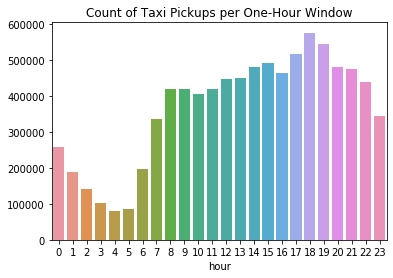

In [6]:
counts = data.groupby('hour').size()
ax = sns.barplot(x=counts.index, y=counts.values)
plt.title('Count of Taxi Pickups per One-Hour Window')


In [7]:
counts.max()

575620

The one-hour window in January 2018 that saw the highest number of taxi pickups was hour 18, or 6 p.m. In this window, there were a total of 575620 taxi pickups.

# Question 2 
### According to ​www.nyc.gov​, the meter (fare_amount) is calculated using a 2.50 base fare plus 0.50 per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped. Use this information to build a model that predicts fare_amount as a function of trip duration, distance, and any other features you feel are appropriate. Were you able to successfully reverse engineer the fare rules?


Before creating a model to predict fare amount, the data needs to be checked for negative or erroneous values so our model is not skewed by these values. I will also analyze the data to see if there are other features that can be added to our model. 

In [8]:
joined_data = data.merge(zones, left_on='DOLocationID', right_on='LocationID')

In [9]:
joined_data['duration'] = pd.to_datetime(joined_data['tpep_dropoff_datetime']) - pd.to_datetime(joined_data['tpep_pickup_datetime'])

joined_data['trip_id'] = joined_data.PULocationID.astype(str) + ':' + joined_data.DOLocationID.astype(str)

In [10]:
joined_data[(joined_data['fare_amount'] < 2.50) & (joined_data['fare_amount'] > 0)]['fare_amount'].value_counts()

0.01    848
2.00     53
1.00     48
1.60     40
1.50     36
1.70     27
1.80     26
0.05     19
1.90     15
2.10     14
1.20     11
1.40     11
1.10     10
2.20      8
0.30      7
1.30      7
0.10      6
2.30      5
0.60      4
0.02      4
2.25      4
0.50      4
0.59      4
0.52      3
0.45      3
2.40      3
0.11      3
0.65      3
1.75      2
1.11      2
       ... 
1.24      1
1.15      1
1.46      1
0.40      1
2.18      1
0.22      1
0.63      1
0.83      1
2.06      1
0.28      1
0.20      1
0.66      1
1.31      1
0.31      1
0.15      1
0.70      1
1.99      1
0.17      1
0.04      1
0.78      1
1.42      1
1.12      1
0.33      1
2.07      1
0.12      1
0.69      1
0.55      1
0.90      1
0.16      1
1.84      1
Name: fare_amount, Length: 66, dtype: int64

Removing fare amounts that are less than or equal to 0, since all fares should be at least $2.50. 

In [11]:
joined_data = joined_data[joined_data['fare_amount']>0]

Removing negative duration values, since all durations of taxi rides must be at least 0 seconds.

In [13]:
joined_data['duration'] = joined_data['duration'].dt.total_seconds()

joined_data = joined_data[joined_data['duration'] > 0]


In [14]:
(joined_data['duration']<0).value_counts()

False    8746085
Name: duration, dtype: int64

Removing negative distance values as well.

In [15]:
(joined_data.trip_distance>0).value_counts()

True     8699761
False      46324
Name: trip_distance, dtype: int64

One-hot encoding the boroughs to see if this feature matrix will help build our model.

In [108]:
pd.get_dummies(joined_data['Borough']).head()


,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island,Unknown
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0


In [18]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

I am using a random sample of the data since the dataset provided was very large, the model would take a very long time to run.

In [109]:
sample = joined_data.sample(n=20000, random_state=1)

In [110]:
X = sample[['duration', 'trip_distance']]
y = sample[['fare_amount']]

In [111]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.8, test_size=0.2)

In [112]:
from sklearn.linear_model import LinearRegression 

model = LinearRegression()
model.fit(X_train, y_train)

rmse(model.predict(X_test) - y_test)

fare_amount    4.138352
dtype: float64

# Question 3 
### What are some features of rides that yield generous (not just large) tips?

The customary tip rate for taxi drivers is 15-20%. A generous tip is one that will be greater than 15%. To look at the tip rate, we can divide the tip amount by the total amount of each trip.

We should also remove any negative values so this does not skew our results.

In [113]:
data['duration'] = pd.to_datetime(data['tpep_dropoff_datetime']) - pd.to_datetime(data['tpep_pickup_datetime'])
data['duration'] = data['duration'].dt.total_seconds()

data = data[data['duration'] > 0]

In [114]:
data['tip_to_total'] = data['tip_amount']/data['fare_amount']

generous = data[data['tip_to_total'] > 0.15]

not_gen = data[data['tip_to_total']<=0.15]

generous.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'hour', 'tip_to_total', 'duration', 'pu_day', 'do_day',
       'day'],
      dtype='object')

In [115]:
generous.payment_type.value_counts()

1    5096534
3        102
4         30
2          4
Name: payment_type, dtype: int64

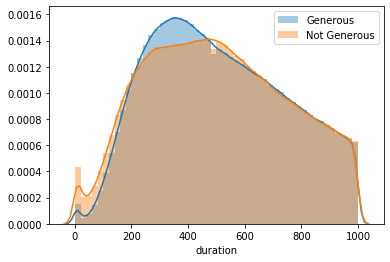

In [55]:
sns.distplot(generous[generous['duration'] <1000].duration, label='Generous')
sns.distplot(not_gen[not_gen['duration']<1000].duration, label='Not Generous')
plt.legend()

The plot above shows that the duration distribution is about the same for generous and non-generous tips.

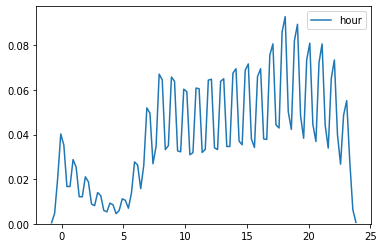

In [56]:
sns.kdeplot(generous.hour)

This KDE plot shows us that there were more generous tips after hour 17 (5 p.m).

Text(0.5, 1.0, 'Number of Generous Tip Rides Based on Borough')

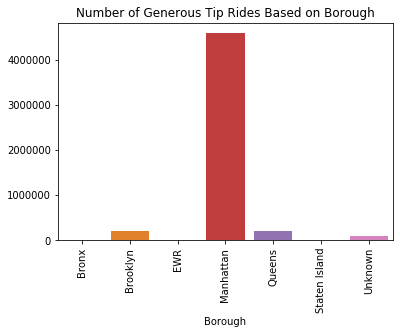

In [57]:
merged_generous = generous.merge(zones, left_on='DOLocationID', right_on='LocationID')
ax = sns.barplot(merged_generous.groupby('Borough').size().index, merged_generous.groupby('Borough').size().values)
x = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Number of Generous Tip Rides Based on Borough')

The trips that had a generous tip were mainly paid with credit card, after hour 17, and dropped off in the Manhattan Borough. 

# Question 4 
### Produce a visualization that shows how demand for taxis depends on both the time of day and day of the week 

In [58]:
data['pu_day'] = pd.to_datetime(data['tpep_pickup_datetime']).dt.dayofweek
data['pu_day'].value_counts()

2    1495695
1    1407663
0    1270878
4    1242723
5    1206608
3    1088986
6    1039701
Name: pu_day, dtype: int64

In [59]:
data['do_day'] = pd.to_datetime(data['tpep_dropoff_datetime']).dt.dayofweek
data['do_day'].value_counts()

2    1494674
1    1406339
0    1269799
4    1237427
5    1205170
3    1089549
6    1049296
Name: do_day, dtype: int64

Text(0.5, 1.0, 'Count of Taxi Pickups per Day of Week')

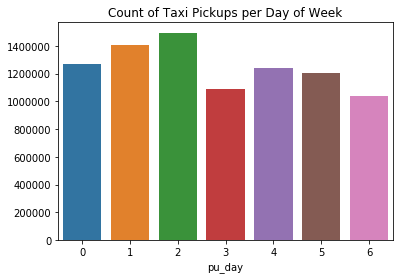

In [60]:
counts = data.groupby('pu_day').size()
sns.barplot(counts.index, counts.values)
plt.title('Count of Taxi Pickups per Day of Week')

Text(0.5, 1.0, 'Count of Taxi Pickups per One-Hour Window')

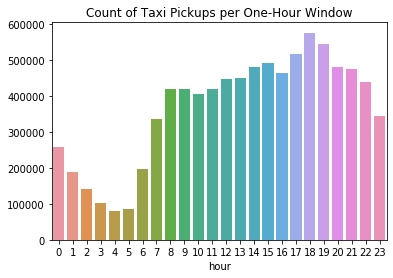

In [61]:
counts = data.groupby('hour').size()
ax = sns.barplot(x=counts.index, y=counts.values)
plt.title('Count of Taxi Pickups per One-Hour Window')

The barplots show that there is a clear hour and day of the week in which there are more taxi rides. Thus, the demand is the greatest on Wednesday's (day 2) and at 6 p.m (hour 18). 

# Question 5 
### Construct a probabilistic model to predict the drop-off borough given relevant input features from the data. Using this model, what is your estimate of the probability that a passenger is dropped off in Queens given she's picked up in Manhattan at 10:12 AM on a Tuesday?


Once again we will clean the data to remove any erroneous values.

In [188]:
# random forest classifier
joined_data = data.merge(zones, left_on='DOLocationID', right_on='LocationID')
joined_data = joined_data[joined_data['trip_distance']>0]
joined_data = joined_data[joined_data['duration']>0]
joined_data['minute'] = pd.to_datetime(joined_data['tpep_pickup_datetime']).dt.minute
joined_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_to_total,duration,pu_day,do_day,day,LocationID,Borough,Zone,service_zone,minute
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.50,1,N,41,24,2,...,0.000000,198.0,0,0,1,24,Manhattan,Bloomingdale,Yellow Zone,21
1,1,2018-01-01 00:56:38,2018-01-01 01:01:05,1,1.00,1,N,238,24,1,...,0.309091,267.0,0,0,1,24,Manhattan,Bloomingdale,Yellow Zone,56
2,2,2018-01-01 00:51:36,2018-01-01 01:04:13,5,2.22,1,N,239,24,2,...,0.000000,757.0,0,0,1,24,Manhattan,Bloomingdale,Yellow Zone,51
3,1,2018-01-01 00:15:00,2018-01-01 00:23:01,1,1.70,1,N,239,24,1,...,0.231250,481.0,0,0,1,24,Manhattan,Bloomingdale,Yellow Zone,15
4,2,2018-01-01 00:59:29,2018-01-01 01:10:14,1,2.16,1,N,239,24,1,...,0.226000,645.0,0,0,1,24,Manhattan,Bloomingdale,Yellow Zone,59


In [189]:
joined_data_sample = joined_data.sample(n=20000, random_state=1)

In [200]:
X = joined_data_sample[['hour', 'duration', 'trip_distance', 'PULocationID', 'passenger_count', 
                 'tip_amount', 'tolls_amount', 'fare_amount', 'do_day', 'pu_day', 'minute']]
y = joined_data_sample['Borough']

In [201]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.8, test_size=0.2)


In [202]:
rf_model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=5
                                          )
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [203]:
pred = rf_model.predict(X_test)
pred

array(['Manhattan', 'Manhattan', 'Manhattan', ..., 'Manhattan',
       'Manhattan', 'Manhattan'], dtype=object)

In [204]:
rf_model.score(X_test, y_test)

0.919

The following code gives us the data observations that were picked up in Manhattan and picked up at 10:12

In [215]:
manhattan = joined_data[(joined_data['Borough']=='Manhattan') & (joined_data['hour']==10) & (joined_data['minute']==12) & (joined_data['pu_day']==1)]
manhattan.shape

(1122, 28)

Picking a random passenger that was picked up in Manhattan at 10:12 on a Tuesday, we predict that he/she was dropped off in Queens, which is the 4th value in the array of the Boroughs.

In [234]:
rf_probs = rf_model.predict_proba(manhattan[['hour', 'duration', 'trip_distance', 'PULocationID', 'passenger_count', 
                 'tip_amount', 'tolls_amount', 'fare_amount', 'do_day', 'pu_day', 'minute']].sample(n=1, random_state=42))[:, 4]
rf_probs

array([0.01439198])

# Question 6 
### Construct and justify a set hypothesis as to how the trip observations would be affected by inclement weather, such as rain or snow. Based on your hypothesis, identify the one-hour window in this data set in which you are most confident that bad weather occurred.

I expect that the overall number of taxi rides will decrease when there is inclement weather. 


In [87]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour,tip_to_total,duration,pu_day,do_day
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,...,0.5,0.00,0.0,0.3,5.80,0,0.000000,198.0,0,0
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,...,0.5,0.00,0.0,0.3,15.30,0,0.000000,1090.0,0,0
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,...,0.5,1.00,0.0,0.3,8.30,0,0.166667,355.0,0,0
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,...,0.5,0.00,0.0,0.3,34.80,0,0.000000,1949.0,0,0
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,...,0.5,2.75,0.0,0.3,16.55,0,0.220000,1068.0,0,0


In [88]:
data['day'] = pd.to_datetime(data['tpep_pickup_datetime']).dt.day

In [100]:
counts = data.groupby('day').size()
counts.head()

day
1    236955
2    237929
3    266769
4    122109
5    265010
dtype: int64

Text(0.5, 1.0, 'Number of Taxi Rides for Each Day of the Month')

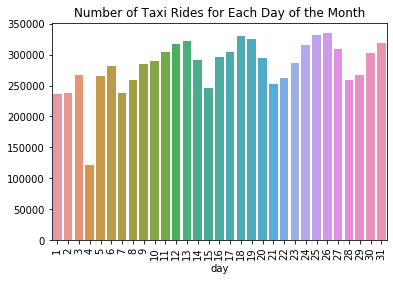

In [90]:
ax = sns.barplot(x=counts.index, y=counts.values)
x = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Number of Taxi Rides for Each Day of the Month')

We know that on the fourth day of the month there was the lowest amount of taxi rides. This is accurate because on January 4th of 2018 there was a huge blizzard in New York. On this day, the roads must have been closed off and people must have stayed inside all day. Since know there was a blizzard on January 4th, I will delve deeper into the fourth day to look at the hours.

In [91]:
fourth_day = data[data['day']==4]
fourth_day.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour,tip_to_total,duration,pu_day,do_day,day
682518,2,2018-01-04 09:44:14,2018-01-04 10:10:39,2,0.00,1,N,264,264,2,...,0.00,0.00,0.3,4.90,9,0.000000,1585.0,3,3,4
716562,2,2018-01-04 11:28:52,2018-01-04 12:13:53,2,0.00,1,N,193,193,2,...,0.00,0.00,0.3,6.70,11,0.000000,2701.0,3,3,4
734044,2,2018-01-04 00:02:07,2018-01-04 00:16:14,1,6.27,1,N,231,141,1,...,2.00,0.00,0.3,22.30,0,0.105263,847.0,3,3,4
734048,2,2018-01-04 00:00:14,2018-01-04 00:19:15,1,9.65,1,N,138,151,1,...,6.91,5.76,0.3,41.47,0,0.251273,1141.0,3,3,4
734633,2,2018-01-04 00:03:01,2018-01-04 00:29:14,1,5.79,1,N,231,17,1,...,4.66,0.00,0.3,27.96,0,0.211818,1573.0,3,3,4


Text(0.5, 1.0, 'Count of Taxi Rides on January 4th by Hour')

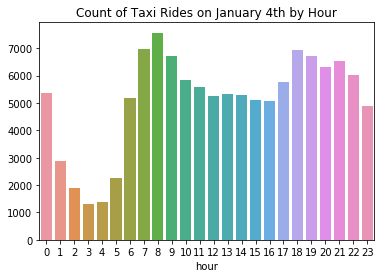

In [104]:
fourth_day_hours = fourth_day.groupby('hour').size()
sns.barplot(fourth_day_hours.index, fourth_day_hours.values)
plt.title('Count of Taxi Rides on January 4th by Hour')

Now, I will compare the values of the "regular" days, or days that aren't blizzards, with the January 4th dataset.

In [105]:
others = data[data['day']!=4]
others.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour,tip_to_total,duration,pu_day,do_day,day
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,...,0.00,0.0,0.3,5.80,0,0.000000,198.0,0,0,1
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,...,0.00,0.0,0.3,15.30,0,0.000000,1090.0,0,0,1
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,...,1.00,0.0,0.3,8.30,0,0.166667,355.0,0,0,1
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,...,0.00,0.0,0.3,34.80,0,0.000000,1949.0,0,0,1
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,...,2.75,0.0,0.3,16.55,0,0.220000,1068.0,0,0,1


In [94]:
avgs = np.zeros(24)
for i in range(1,32):
    other_day = others[others['day'] == i]
    if other_day.shape[0] > 0:
        avgs += other_day.groupby('hour').size().values
avgs /= 30

For the "regular" days, I took the average count of rides per hour of each day. Then I will compare the amount which the count of rides in an hour changed on a regular day vs the blizzard day.

In [106]:
avgs

array([ 8454.53333333,  6185.8       ,  4667.63333333,  3373.26666667,
        2595.86666667,  2794.7       ,  6387.        , 10947.46666667,
       13681.6       , 13766.33333333, 13321.86666667, 13755.2       ,
       14715.13333333, 14791.3       , 15783.66666667, 16172.73333333,
       15282.43333333, 17053.46666667, 18939.13333333, 17868.56666667,
       15832.23333333, 15607.36666667, 14437.7       , 11256.5       ])

In [107]:
np.argmax(abs(fourth_day_hours - avgs) / avgs)

15

At hour 15 (3 p.m.), there was the most change in amount of taxi rides on a snowy day vs a regular day. If we wanted to analyze it more, we could look at specifically the fourth day of January and the durations and distances of each ride. These two variables can differ though because on one hand if the weather is inclement, the distances and durations would be shorter since more people want to take a taxi instead of walking. On the other hand, there would be less overall taxi rides so these values would not mean much.